# CITE-seq and ASAP-seq integration using scJoint

In this tutorial, we will illustrate the utility of scJoint step by step using CITE-seq and ASAP-seq PBMC data from control condition generated by Mimitou et al. 2020. CITE-seq is a technology that allow profiles of gene expression and protein abundance simultaneously. Similarly, ASAP-seq can simultaneously profile accessible chromatin and protein levels in thousands of single cells. We can use scJoint to perform integration analysis of CITE-seq and ASAP-seq by concatenating gene expression or gene activity vectors with protein measurements.
The data can be downoladed from GSE156478. After preprocessing, quality control and cell type annotation, the data contains 4644 cells from CITE-seq data and 4502 cells from ASAP-seq data.

In [1]:
import process_db
import h5py
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(1)

## Preparing input for scJoint

The data is provided in the github repository (data.zip).

In [2]:
rna_h5_files = ["data/citeseq_control_rna.h5"] 
rna_label_files = ["data/citeseq_control_cellTypes.csv"] # csv file

atac_h5_files = ["data/asapseq_control_atac.h5"]
atac_label_files = ["data/asapseq_control_cellTypes.csv"]

rna_protein_files = ["data/citeseq_control_adt.h5"] 
atac_protein_files = ["data/asapseq_control_adt.h5"] 

scJoint requires expression data saved as .h5 files as input. The .h5 files should include a group "matrix" with 'barcodes', 'data', 'features'. The gene expression data (gene by cell) is stored in "matrix/data", which can be extracted using `h5['matrix/data']`. Since scJoint will transform all expression data into binary, both normalised and raw counts data can be used as input. With the .h5 file, we can use `data_parsing` function to read the data in and save the data into `.npz` format which will be saved in the same folder of .h5 files.

In [3]:
h5 = h5py.File(rna_h5_files[0], "r")
print(list(h5.keys()))
print(h5["matrix"].keys())
h5_data = h5['matrix/data']
print(h5_data.shape)
process_db.data_parsing(rna_h5_files, atac_h5_files)
process_db.data_parsing(rna_protein_files, atac_protein_files)

['matrix']
<KeysViewHDF5 ['barcodes', 'data', 'features']>
(17441, 4644)
H5 dataset shape: (17441, 4644)
H5 dataset shape: (17441, 4502)
H5 dataset shape: (227, 4644)
H5 dataset shape: (227, 4502)


scJoint trains on scRNA-seq (CITE-seq) cell type labels and predict the labels for scATAC-seq (ASAP-seq), which requires the cell type labels from scRNA-seq as input. `label_parsing` function will covert the cell type names into numeric and output a file `label_to_idx.txt` as a dictionary of cell type labels to numeric .

Noted that the cell type labels for scATAC-seq is an optional input. 

In [4]:
rna_label = pd.read_csv(rna_label_files[0], index_col = 0)
rna_label
print(rna_label.value_counts(sort = False))
atac_label = pd.read_csv(atac_label_files[0], index_col = 0)
atac_label
print(atac_label.value_counts(sort = False))

x              
B                   263
Effector CD4+ T    1079
Effector CD8+ T     378
Monocytes           180
NK                  594
Naive CD4+ T       1480
Naive CD8+ T        670
dtype: int64
x              
B                   355
DC                  203
Effector CD4+ T     935
Effector CD8+ T     362
Monocytes           583
NK                  428
Naive CD4+ T       1056
Naive CD8+ T        438
unknown             142
dtype: int64


In [5]:
process_db.label_parsing(rna_label_files, atac_label_files)

{'B': 0, 'Effector CD4+ T': 1, 'Effector CD8+ T': 2, 'Monocytes': 3, 'NK': 4, 'Naive CD4+ T': 5, 'Naive CD8+ T': 6}


## Running scJoint

The CITE-seq and ASAP-seq have 17441 genes and 227 proteins in common. We will concatenate the two modality when performing scJoint, therefore the input size of this case is 17441 + 227 = 17668. And we have 7 cell types in total in the CITE-seq adta, so we will set the number of class as 7 in the `config.py` file. The paths also needed to be edited accordingly. Here are the settings for CITE-seq and ASAP-seq control condition data we used:

```
self.number_of_class = 7 # Number of cell types in CITE-seq data
self.input_size = 17668 # Number of common genes and proteins between CITE-seq data and ASAP-seq
self.rna_paths = ['data/citeseq_control_rna.npz'] # RNA gene expression from CITE-seq data
self.rna_labels = ['data/citeseq_control_cellTypes.txt'] # CITE-seq data cell type labels (coverted to numeric) 
self.atac_paths = ['data/asapseq_control_atac.npz'] # ATAC gene activity matrix from ASAP-seq data
self.atac_labels = ['data/asapseq_control_cellTypes.txt'] # ASAP-seq data cell type labels (coverted to numeric) 
self.rna_protein_paths = ['data/citeseq_control_adt.npz'] # Protein expression from CITE-seq data
self.atac_protein_paths = ['data/asapseq_control_adt.npz'] # Protein expression from ASAP-seq data

# Training config            
self.batch_size = 256
self.lr_stage1 = 0.01
self.lr_stage3 = 0.01
self.lr_decay_epoch = 20
self.epochs_stage1 = 20
self.epochs_stage3 = 20
self.p = 0.8
self.embedding_size = 64
self.momentum = 0.9
self.center_weight = 1
self.num_threads = 1
self.seed = 1
self.checkpoint = ''    
```

After modifying `config.py`, we are ready to run scJoint in terminal with

```
python3 main.py
```

This takes ~4 minutes using 1 thread for PyTorch.

## Visualisation

The output files of scJoint are stored in `./output` folder. The embeddings are stored in `*_embeddings.txt` files. Dimension reduction methods like tSNE and UMAP can be applied on the embeddings files for visualisations.

In [6]:
rna_embeddings = np.loadtxt('./output/citeseq_control_rna_embeddings.txt')
atac_embeddings = np.loadtxt('./output/asapseq_control_atac_embeddings.txt')
print(rna_embeddings.shape)
print(atac_embeddings.shape)
embeddings =  np.concatenate((rna_embeddings, atac_embeddings))
print(embeddings.shape)
tsne_results = TSNE(perplexity=30, n_iter = 1000).fit_transform(embeddings)
tsne_results.shape
df = pd.DataFrame()
df['tSNE1'] = tsne_results[:,0]
df['tSNE2'] = tsne_results[:,1]

(4644, 64)
(4502, 64)
(9146, 64)


The ATAC-seq prediction results are saved in `*_knn_predictions.txt` which stored the numeric labels of the predictions. The numeric labels can be mapped to the original cell type labels using the `label_to_idx.txt` file in data input folder.

In [7]:
rna_labels = np.loadtxt('./data/citeseq_control_cellTypes.txt')
atac_labels = np.loadtxt('./data/asapseq_control_cellTypes.txt')
atac_predictions = np.loadtxt('./output/asapseq_control_atac_knn_predictions.txt')
labels =  np.concatenate((rna_labels, atac_predictions))
label_to_idx = pd.read_csv('./data/label_to_idx.txt', sep = '\t', header = None)
label_to_idx.shape
label_dic = []
for i in range(label_to_idx.shape[0]):
    label_dic = np.append(label_dic, label_to_idx[0][i][:-2])

In [8]:
common_label_cnt = 0
correct = 0
for i in range(len(atac_labels)):
    if atac_labels[i] >= 0:
        common_label_cnt += 1
        if atac_labels[i] == atac_predictions[i]:
            correct += 1
correct/common_label_cnt

0.9263892229973538

The accuracy rate of the common cell types is 93%. Finally, we will visualise the tSNE plot by highlighting the batch and the cell type resepctively.

In [9]:
data_label = np.array(["CITE-seq", "ASAP-seq"])
df['data'] = np.repeat(data_label, [rna_embeddings.shape[0], atac_embeddings.shape[0]], axis=0)
df['predicted'] = label_dic[labels.astype(int)]

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

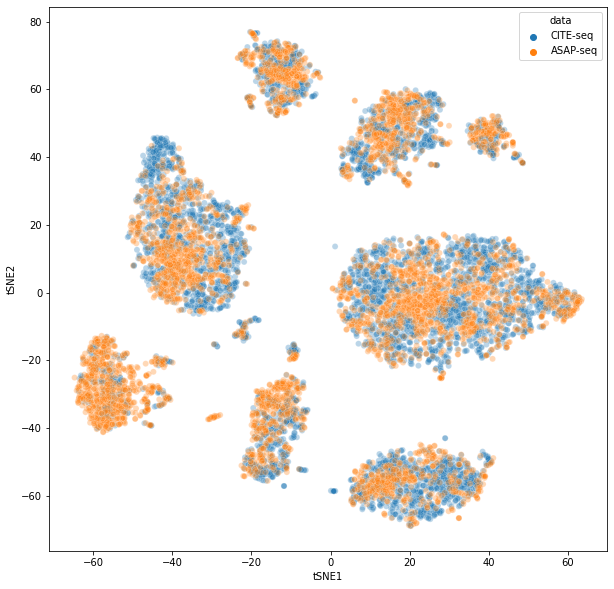

In [10]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x = "tSNE1", y = "tSNE2",
    hue = "data",
    palette = sns.color_palette("tab10", 2),
    data = df,
    legend = "full",
    alpha = 0.3
)

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

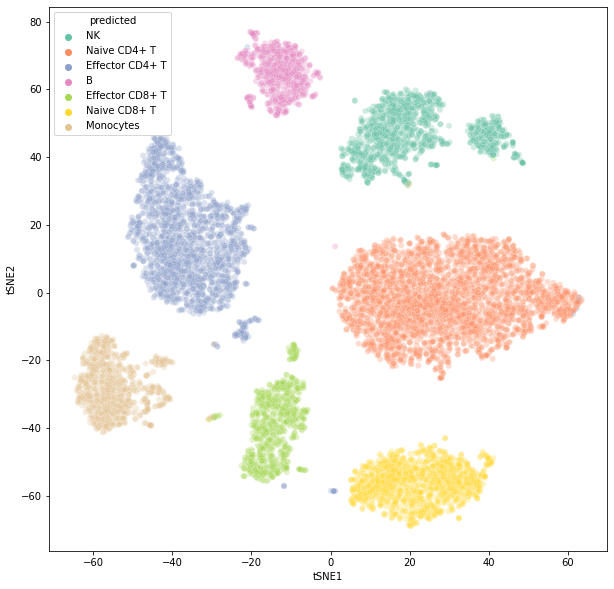

In [11]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x = "tSNE1", y = "tSNE2",
    hue = "predicted",
    palette = sns.color_palette("Set2", 7),
    data = df,
    legend = "full",
    alpha = 0.3
)